This is the current Neural Net file, begun as AWS Sagemaker processing.  My GPU is ~88x faster than free AWS Sagemaker computing 
meaning I can train more in 3 hours on my PC than I could in 250 hours of free compute time on AWS Sagemaker

In [13]:
# !pip install sagemaker ipywidgets --upgrade --quiet

In [1]:
# import sagemaker, boto3, json
# from sagemaker.session import Session

# sagemaker_session = Session()
# aws_role = sagemaker_session.get_caller_identity_arn()
# aws_region = boto3.Session().region_name
# sess = sagemaker.Session()

In [ ]:
# s3_bucket = "BUCKET ID HERE"
# s3 = boto3.client("s3")
# s3.download_file(s3_bucket, "TestValTrain/val.tfrecord.gz", "val.tfrecord.gz")
# s3.download_file(s3_bucket, "TestValTrain/test.tfrecord.gz", "test.tfrecord.gz")

In [ ]:
import time
import sys
import os
import glob
import math
import threading
import concurrent.futures as cf
import random
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input, Model, layers, metrics, losses, callbacks, optimizers, models, utils
from keras import backend as K
import gc
import keras_tuner as kt
from pyfaidx import Fasta

K.clear_session()
gc.collect()

datasets_path = "../../Datasets/"
models_path = "../../Models/"

2025-03-15 04:00:20.848706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-15 04:00:21.071367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-15 04:00:21.136924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 04:00:21.585002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-15 04:00:23.418022: W tensorflow/compiler/tf2

0

In [4]:
@utils.register_keras_serializable()
class CustomNoBackgroundF1Score(metrics.Metric):
    def __init__(self, num_classes, average='weighted', threshold=0.5, name='no_background_f1', **kwargs):
        """
        Custom F1 score metric that only considers non-dominant classes (ignoring index 0).
        
        This version is designed for multi-encoded labels where:
          - The dominant class (index 0) is represented as a hard label [1, 0, 0, ...]
          - For non-dominant classes (indices 1 to num_classes-1), only an exact label of 1 is considered positive.
            (Any partial credit/smoothed values below 1 are treated as 0.)
          - Predictions are thresholded (default threshold = 0.5) to decide 1 vs. 0.
        
        Args:
            num_classes (int): Total number of classes.
            average (str): 'weighted' (default) to weight by support or 'macro' for a simple average.
            threshold (float): Threshold on y_pred to decide a positive (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average

        # Create state variables to accumulate counts for each class.
        # We use a vector of length num_classes but we will update only indices 1...num_classes-1.
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the metric state.
        
        Args:
            y_true: Tensor of shape (batch_size, num_classes). These are multi-encoded labels.
                    For non-dominant classes, a label is considered positive only if it is exactly 1.
            y_pred: Tensor of shape (batch_size, num_classes) with predictions (e.g. probabilities).
            sample_weight: Optional sample weights.
        """
        
        # Flatten all dimensions except the last one (which should be num_classes).
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])
        
        # We want to ignore the dominant class (index 0) and work on classes 1...num_classes-1.
        # Assume y_true and y_pred are both of shape (batch_size, num_classes).
        y_true_non_dominant = y_true[:, 1:]
        y_pred_non_dominant = y_pred[:, 1:]
        
        # For ground truth: treat a class as positive only if its value is exactly 1.
        one_value = tf.cast(1.0, dtype=y_true_non_dominant.dtype)
        y_true_bin = tf.cast(tf.equal(y_true_non_dominant, one_value), tf.int32)
        # For predictions: apply thresholding.
        y_pred_bin = tf.cast(y_pred_non_dominant >= self.threshold, tf.int32)
        
        # (Optionally) apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.int32)
            sample_weight = tf.reshape(sample_weight, (-1, 1))
            y_true_bin = y_true_bin * sample_weight
            y_pred_bin = y_pred_bin * sample_weight
        
        # Compute per-class true positives, false positives, and false negatives for non-dominant classes.
        tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_bin) * y_pred_bin, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), tf.float32), axis=0)
        
        # Our state variables have length num_classes. We want to update only indices 1... with our computed values.
        zeros = tf.zeros([1], dtype=tf.float32)
        tp_update = tf.concat([zeros, tp], axis=0)
        fp_update = tf.concat([zeros, fp], axis=0)
        fn_update = tf.concat([zeros, fn], axis=0)
        
        self.true_positives.assign_add(tp_update)
        self.false_positives.assign_add(fp_update)
        self.false_negatives.assign_add(fn_update)

    def result(self):
        """
        Computes the F1 score over the non-dominant classes (indices 1...num_classes-1).
        """
        # Select non-dominant classes only.
        tp = self.true_positives[1:]
        fp = self.false_positives[1:]
        fn = self.false_negatives[1:]
        
        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall = tf.math.divide_no_nan(tp, tp + fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        if self.average == 'weighted':
            support = tp + fn
            weighted_f1 = tf.reduce_sum(f1 * support) / (tf.reduce_sum(support) + K.epsilon())
            return weighted_f1
        else:  # macro
            return tf.reduce_mean(f1)

    def reset_states(self):
        """
        Resets all of the metric state variables.
        """
        for v in self.variables:
            v.assign(tf.zeros_like(v))
            
    def get_config(self):
        """
        Returns the configuration of the metric, so it can be recreated later.
        """
        config = super(CustomNoBackgroundF1Score, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'average': self.average,
            'threshold': self.threshold,
        })
        return config

@utils.register_keras_serializable()
class CustomConditionalF1Score(metrics.Metric):
    def __init__(self, threshold=0.5, average='weighted', filter_mode='either', name='conditional_f1', **kwargs):
        """
        Custom F1 score metric that computes the F1 score only for target columns (columns 1-4).
        Additionally, only rows meeting a filtering criterion are included in the calculation.
        
        Args:
            threshold (float): Threshold on y_pred to decide a positive (default = 0.5).
            average (str): 'weighted' (default) to weight by support or 'macro' for a simple average.
            filter_mode (str): Determines which rows to include based on the target columns.
                               Options:
                                  - 'pred': Only rows where y_pred (after thresholding) has at least one 1.
                                  - 'true': Only rows where y_true (exactly equal to 1) has at least one 1.
                                  - 'either': Rows where either y_true or y_pred has at least one 1.
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        
        Note:
            This metric only tracks columns 1-4 (0-indexed). Column 0 (the dominant background class)
            is ignored completely.
        """
        metric_name = f'{name}_{filter_mode}'
        
        super(CustomConditionalF1Score, self).__init__(name=metric_name, **kwargs)
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average
        
        if filter_mode not in ['pred', 'true', 'either']:
            raise ValueError("filter_mode must be 'pred', 'true', or 'either'")
        self.filter_mode = filter_mode
        
        # We are tracking only 4 target columns (columns 1 to 4).
        self.num_target_columns = 4
        self.true_positives = self.add_weight(
            name='tp', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Reshape inputs so that the last dimension is the number of classes.
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        # Only consider columns 1-4 (ignoring index 0).
        y_true_subset = y_true[:, 1:5]
        y_pred_subset = y_pred[:, 1:5]
        
        # For ground truth, treat a label as positive only if its value is exactly 1.
        y_true_bin = tf.cast(tf.equal(y_true_subset, 1.0), tf.int32)
        # For predictions, apply the threshold to decide 1 vs. 0.
        y_pred_bin = tf.cast(y_pred_subset >= self.threshold, tf.int32)
        
        # Compute a row-level mask based on the filter_mode.
        if self.filter_mode == 'pred':
            mask = tf.reduce_any(tf.equal(y_pred_bin, 1), axis=1)
        elif self.filter_mode == 'true':
            mask = tf.reduce_any(tf.equal(y_true_bin, 1), axis=1)
        else:  # 'either'
            mask = tf.logical_or(
                tf.reduce_any(tf.equal(y_pred_bin, 1), axis=1),
                tf.reduce_any(tf.equal(y_true_bin, 1), axis=1)
            )
        
        # Apply the mask so only selected rows are used for the metric update.
        y_true_filtered = tf.boolean_mask(y_true_bin, mask)
        y_pred_filtered = tf.boolean_mask(y_pred_bin, mask)
        
        # Optionally apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.reshape(sample_weight, [-1, 1])
            y_true_filtered = y_true_filtered * sample_weight
            y_pred_filtered = y_pred_filtered * sample_weight
        
        # Compute per-column true positives, false positives, and false negatives.
        tp = tf.reduce_sum(tf.cast(y_true_filtered * y_pred_filtered, tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_filtered) * y_pred_filtered, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_filtered * (1 - y_pred_filtered), tf.float32), axis=0)
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_positives)
        recall = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        if self.average == 'weighted':
            support = self.true_positives + self.false_negatives
            return tf.reduce_sum(f1 * support) / (tf.reduce_sum(support) + K.epsilon())
        else:  # 'macro'
            return tf.reduce_mean(f1)

    def reset_states(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))
            
    def get_config(self):
        config = super(CustomConditionalF1Score, self).get_config()
        config.update({
            'threshold': self.threshold,
            'average': self.average,
            'filter_mode': self.filter_mode,
        })
        return config


@utils.register_keras_serializable()
class CustomFalsePositiveDistance(metrics.Metric):
    def __init__(self, num_classes, threshold=0.5, window=100, name='false_positive_distance', **kwargs):
        """
        Metric that accumulates a running average “distance” error for false positive predictions,
        ignoring the dominant (background) class (index 0).

        For each false positive (i.e. a prediction >= threshold when the strict label is not 1),
        the distance is computed from the raw label value (which encodes proximity to an actual annotation)
        as follows:

            distance = 1 + ((max_credit - v) * (window / max_credit))

        where:
            - v is the raw label value at that position,
            - max_credit is the maximum smoothing credit (0.5 in our scheme), so that if v == 0.5 the distance is 1,
              and if v == 0 the distance is 1 + window (i.e. 101 for window=100).

        Args:
            num_classes (int): Total number of classes.
            threshold (float): Threshold on y_pred to decide a positive.
            window (int): Window size used in the smoothing scheme.
            name (str): Name of the metric.
        """
        super(CustomFalsePositiveDistance, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        self.window = float(window)
        self.max_credit = 0.5  # Based on your smoothing scheme.

        # State variables to accumulate total distance and count of false positives.
        self.total_distance = self.add_weight(
            name='total_distance', initializer='zeros', dtype=tf.float32
        )
        self.false_positive_count = self.add_weight(
            name='false_positive_count', initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        For non-dominant classes (indices 1:), this method:
          - thresholds predictions,
          - identifies false positives (prediction is positive while strict label != 1),
          - computes the distance error from the raw (smoothed) label value, and
          - accumulates the sum of distances and count of false positives.
        """
        # Ensure shape (batch_size, num_classes)
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])

        # Ignore the dominant/background class (index 0)
        y_true_non = y_true[:, 1:]
        y_pred_non = y_pred[:, 1:]

        # Threshold predictions
        y_pred_bin = tf.cast(y_pred_non >= self.threshold, tf.float32)

        # For strict classification, a label is positive only if it is exactly 1.
        # So a false positive is when y_pred_bin==1 but y_true (strict) is not 1.
        # (This is similar to your F1 metric, i.e. smoothing values are treated as negatives.)
        false_positive_mask = tf.logical_and(
            tf.equal(y_pred_bin, 1.0),
            tf.not_equal(y_true_non, 1.0)
        )
        false_positive_mask = tf.cast(false_positive_mask, tf.float32)

        # Compute distance per element.
        # In our smoothing scheme:
        #   - At a true annotation (v = 1), we wouldn’t count a false positive.
        #   - In a smoothed region, the maximum credit is 0.5.
        #   - We define:
        #       distance = 1 + ((max_credit - v) * (window / max_credit))
        #     so that if v == 0.5, distance = 1, and if v == 0, distance = 1 + window.
        distance = 1.0 + (self.max_credit - y_true_non) * (self.window / self.max_credit)
        distance = tf.where(distance >= 101.0, tf.constant(125.0, dtype=distance.dtype), distance)

        # Only include entries that are false positives.
        false_positive_distance = distance * false_positive_mask

        # Sum distances and count false positives.
        sum_distance = tf.reduce_sum(false_positive_distance)
        count = tf.reduce_sum(false_positive_mask)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.reshape(sample_weight, [-1, 1])
            sum_distance = tf.reduce_sum(false_positive_distance * sample_weight)
            count = tf.reduce_sum(false_positive_mask * sample_weight)

        self.total_distance.assign_add(sum_distance)
        self.false_positive_count.assign_add(count)

    def result(self):
        """Returns the average distance error over all false positives (or 0 if none)."""
        return tf.math.divide_no_nan(self.total_distance, self.false_positive_count)

    def reset_states(self):
        """Resets the accumulated total distance and count."""
        self.total_distance.assign(0.0)
        self.false_positive_count.assign(0.0)

    def get_config(self):
        config = super(CustomFalsePositiveDistance, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'threshold': self.threshold,
            'window': self.window,
        })
        return config

@utils.register_keras_serializable()
class CustomNoBackgroundAUC(metrics.Metric):
    def __init__(self, curve='PR', name='no_background_auc', **kwargs):
        """
        Custom AUC metric computed only for columns 1-4.

        Args:
            curve (str): The type of AUC curve to use, e.g. 'ROC' (default) or 'PR'.
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundAUC, self).__init__(name=name, **kwargs)
        # Store the curve parameter as a string to aid serialization.
        self.curve = curve  
        # Create one AUC metric per target column (columns 1-4).
        self.auc_metrics = [
            metrics.AUC(curve=self.curve, name=f'auc_col_{i+1}')
            for i in range(4)
        ]

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure inputs are 2D tensors with shape (batch_size, num_classes).
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        # Select target columns (1-4) and ignore background (column 0).
        y_true_subset = y_true[:, 1:5]
        y_pred_subset = y_pred[:, 1:5]
        # For each target column, update the corresponding AUC metric.
        for i, auc_metric in enumerate(self.auc_metrics):
            # Ground truth: positive only if exactly equal to 1.
            y_true_col = tf.cast(tf.equal(y_true_subset[:, i], 1.0), tf.float32)
            y_pred_col = y_pred_subset[:, i]
            if sample_weight is not None:
                sample_weight = tf.reshape(sample_weight, [-1])
                auc_metric.update_state(y_true_col, y_pred_col, sample_weight=sample_weight)
            else:
                auc_metric.update_state(y_true_col, y_pred_col)

    def result(self):
        # Average AUC over all target columns.
        auc_results = [auc_metric.result() for auc_metric in self.auc_metrics]
        return tf.reduce_mean(auc_results)

    def reset_states(self):
        for auc_metric in self.auc_metrics:
            auc_metric.reset_states()

    def get_config(self):
        config = super(CustomNoBackgroundAUC, self).get_config()
        # Return the curve as a string.
        config.update({
            'curve': self.curve,
        })
        return config

@utils.register_keras_serializable()
class CustomNoBackgroundAccuracy(metrics.Metric):
    def __init__(self, threshold=0.5, name='no_background_accuracy', **kwargs):
        """
        Custom accuracy metric computed only for columns 1-4.

        Args:
            threshold (float): Threshold for y_pred (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundAccuracy, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros', dtype=tf.float32)
        self.total_count = self.add_weight(name='total_count', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Reshape inputs to 2D tensors.
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        # Extract columns 1-4.
        y_true_subset = y_true[:, 1:5]
        y_pred_subset = y_pred[:, 1:5]
        # Binarize ground truth: positive if exactly 1.
        y_true_bin = tf.cast(tf.equal(y_true_subset, 1.0), tf.int32)
        # Binarize predictions using the threshold.
        y_pred_bin = tf.cast(y_pred_subset >= self.threshold, tf.int32)
        # Element-wise correctness.
        correct = tf.cast(tf.equal(y_true_bin, y_pred_bin), tf.float32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            # Tile sample weights to match the shape of correct.
            sample_weight = tf.tile(sample_weight, [1, tf.shape(correct)[1]])
            correct = correct * sample_weight
            count = tf.reduce_sum(sample_weight)
        else:
            count = tf.cast(tf.size(correct), tf.float32)
        self.total_correct.assign_add(tf.reduce_sum(correct))
        self.total_count.assign_add(count)

    def result(self):
        return tf.math.divide_no_nan(self.total_correct, self.total_count)

    def reset_states(self):
        self.total_correct.assign(0)
        self.total_count.assign(0)

    def get_config(self):
        config = super(CustomNoBackgroundAccuracy, self).get_config()
        config.update({'threshold': self.threshold})
        return config

@utils.register_keras_serializable()
class CustomNoBackgroundPrecision(metrics.Metric):
    def __init__(self, threshold=0.5, average='weighted', name='no_background_precision', **kwargs):
        """
        Custom precision metric computed only for columns 1-4.

        Args:
            threshold (float): Threshold for y_pred (default 0.5).
            average (str): 'weighted' (default) or 'macro'.
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundPrecision, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average
        self.num_target_columns = 4
        self.true_positives = self.add_weight(
            name='tp', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )
        # For weighted averaging, we also need the support (true positives + false negatives).
        self.false_negatives = self.add_weight(
            name='fn', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Reshape inputs.
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        # Extract target columns (1-4).
        y_true_subset = y_true[:, 1:5]
        y_pred_subset = y_pred[:, 1:5]
        # Binarize ground truth and predictions.
        y_true_bin = tf.cast(tf.equal(y_true_subset, 1.0), tf.int32)
        y_pred_bin = tf.cast(y_pred_subset >= self.threshold, tf.int32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.tile(sample_weight, [1, tf.shape(y_true_bin)[1]])
            y_true_bin = y_true_bin * tf.cast(sample_weight, tf.int32)
            y_pred_bin = y_pred_bin * tf.cast(sample_weight, tf.int32)
        # Compute counts per column.
        tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_bin) * y_pred_bin, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), tf.float32), axis=0)
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Precision: TP / (TP + FP)
        precision = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_positives)
        if self.average == 'weighted':
            # Weight each column by its support (TP + FN).
            support = self.true_positives + self.false_negatives
            weighted_precision = tf.reduce_sum(precision * support) / (tf.reduce_sum(support) + K.epsilon())
            return weighted_precision
        else:  # macro
            return tf.reduce_mean(precision)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

    def get_config(self):
        config = super(CustomNoBackgroundPrecision, self).get_config()
        config.update({
            'threshold': self.threshold,
            'average': self.average,
        })
        return config


@utils.register_keras_serializable()
class CustomNoBackgroundRecall(metrics.Metric):
    def __init__(self, threshold=0.5, average='weighted', name='no_background_recall', **kwargs):
        """
        Custom recall metric computed only for columns 1-4.

        Args:
            threshold (float): Threshold for y_pred (default 0.5).
            average (str): 'weighted' (default) or 'macro'.
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNoBackgroundRecall, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average
        self.num_target_columns = 4
        self.true_positives = self.add_weight(
            name='tp', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(self.num_target_columns,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Reshape inputs.
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        # Extract target columns (1-4).
        y_true_subset = y_true[:, 1:5]
        y_pred_subset = y_pred[:, 1:5]
        # Binarize ground truth and predictions.
        y_true_bin = tf.cast(tf.equal(y_true_subset, 1.0), tf.int32)
        y_pred_bin = tf.cast(y_pred_subset >= self.threshold, tf.int32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.tile(sample_weight, [1, tf.shape(y_true_bin)[1]])
            y_true_bin = y_true_bin * tf.cast(sample_weight, tf.int32)
            y_pred_bin = y_pred_bin * tf.cast(sample_weight, tf.int32)
        # Compute per-column true positives and false negatives.
        tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), tf.float32), axis=0)
        self.true_positives.assign_add(tp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Recall: TP / (TP + FN)
        recall = tf.math.divide_no_nan(self.true_positives, self.true_positives + self.false_negatives)
        if self.average == 'weighted':
            support = self.true_positives + self.false_negatives
            weighted_recall = tf.reduce_sum(recall * support) / (tf.reduce_sum(support) + K.epsilon())
            return weighted_recall
        else:
            return tf.reduce_mean(recall)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

    def get_config(self):
        config = super(CustomNoBackgroundRecall, self).get_config()
        config.update({
            'threshold': self.threshold,
            'average': self.average,
        })
        return config


In [5]:
@utils.register_keras_serializable()
class CustomBackgroundOnlyF1Score(metrics.Metric):
    def __init__(self, num_classes, average='weighted', threshold=0.5, name='background_only_f1', **kwargs):
        """
        Custom F1 score metric that only considers the dominant (background) class (index 0).

        This metric is designed for multi-encoded labels where:
          - The dominant class (index 0) aka background is represented as a hard label [1, 0, 0, ...].
          - For the dominant class, a label is considered positive only if it is exactly 1.
          - Predictions are thresholded (default threshold = 0.5) to decide 1 vs. 0.

        Args:
            num_classes (int): Total number of classes.
            average (str): 'weighted' (default) or 'macro'. (Since only one class is considered, this
                           choice won’t make much difference.)
            threshold (float): Threshold on y_pred to decide a positive (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomBackgroundOnlyF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average

        # We still create vectors of length num_classes, but will only update index 0.
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the metric state using only the dominant class (index 0).

        Args:
            y_true: Tensor of shape (batch_size, num_classes). For the dominant class,
                    a label is considered positive only if it is exactly 1.
            y_pred: Tensor of shape (batch_size, num_classes) (e.g. probabilities).
            sample_weight: Optional sample weights.
        """
        # Reshape to (-1, num_classes) in case additional dimensions exist.
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])

        # Extract the dominant class (index 0)
        y_true_dominant = y_true[:, 0]
        y_pred_dominant = y_pred[:, 0]

        # For ground truth, treat as positive only if exactly equal to 1.
        one_value = tf.cast(1.0, dtype=y_true_dominant.dtype)
        y_true_bin = tf.cast(tf.equal(y_true_dominant, one_value), tf.float32)

        # For predictions, apply thresholding.
        y_pred_bin = tf.cast(y_pred_dominant >= self.threshold, tf.float32)

        # Optionally apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            sample_weight = tf.reshape(sample_weight, [-1])
            y_true_bin = y_true_bin * sample_weight
            y_pred_bin = y_pred_bin * sample_weight

        # Compute true positives, false positives, and false negatives for the dominant class.
        tp = tf.reduce_sum(y_true_bin * y_pred_bin)
        fp = tf.reduce_sum((1 - y_true_bin) * y_pred_bin)
        fn = tf.reduce_sum(y_true_bin * (1 - y_pred_bin))

        # We create update vectors that place the computed scalar at index 0 and zeros elsewhere.
        zeros = tf.zeros([self.num_classes - 1], dtype=tf.float32)
        tp_update = tf.concat([[tp], zeros], axis=0)
        fp_update = tf.concat([[fp], zeros], axis=0)
        fn_update = tf.concat([[fn], zeros], axis=0)

        self.true_positives.assign_add(tp_update)
        self.false_positives.assign_add(fp_update)
        self.false_negatives.assign_add(fn_update)

    def result(self):
        """
        Computes the F1 score for the dominant (background) class (index 0).
        """
        tp = self.true_positives[0]
        fp = self.false_positives[0]
        fn = self.false_negatives[0]

        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall = tf.math.divide_no_nan(tp, tp + fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)

        # Although averaging is not critical with a single class, we mirror the interface.
        if self.average == 'weighted':
            support = tp + fn
            weighted_f1 = tf.math.divide_no_nan(f1 * support, support + K.epsilon())
            return weighted_f1
        else:  # macro
            return f1

    def reset_states(self):
        """
        Resets all of the metric state variables.
        """
        for v in self.variables:
            v.assign(tf.zeros_like(v))
            
    def get_config(self):
        """
        Returns the configuration of the metric, so it can be recreated later.
        """
        config = super(CustomBackgroundOnlyF1Score, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'average': self.average,
            'threshold': self.threshold,
        })
        return config

In [6]:
@utils.register_keras_serializable()
class CustomBinaryFocalLoss(losses.Loss):
    def __init__(self,
                 dominant_class_index=0,
                 # Dominant class multipliers
                 dominant_correct_multiplier=0.99,    # Reward when dominant class is correct
                 dominant_incorrect_multiplier=2.5,     # Penalty when dominant class is incorrect
                 # Expanded non-dominant multipliers for hard labels
                 other_class_true_positive_multiplier=0.05,   # Reward when y_true==1 and prediction is positive
                 other_class_false_negative_multiplier=3.0,     # Punish when y_true==1 but prediction is negative
                 other_class_false_positive_multiplier=1.0,     # Punish when y_true==0 but prediction is positive
                 other_class_true_negative_multiplier=0.99,     # Reward when y_true==0 and prediction is negative
                 # For smoothed labels (0 < y_true < 1)
                 smoothing_multiplier=0.5,              # Scales the effect of a smoothed label
                 smoothing_as_correct=True,             # If True, a high prediction on a smoothed label is rewarded; else, punished
                 threshold=0.5,                         # Threshold to decide if a prediction is "positive"
                 # Focal loss parameters
                 focal_gamma=2.0,                       # Focusing parameter gamma
                 focal_alpha=0.25,                      # Balance parameter alpha
                 name="custom_binary_focal_loss",
                 reduction="sum_over_batch_size"):
        super().__init__(name=name)
        self.dominant_class_index = dominant_class_index
        self.dominant_correct_multiplier = dominant_correct_multiplier
        self.dominant_incorrect_multiplier = dominant_incorrect_multiplier

        self.other_class_true_positive_multiplier = other_class_true_positive_multiplier
        self.other_class_false_negative_multiplier = other_class_false_negative_multiplier
        self.other_class_false_positive_multiplier = other_class_false_positive_multiplier
        self.other_class_true_negative_multiplier = other_class_true_negative_multiplier

        self.smoothing_multiplier = smoothing_multiplier
        self.smoothing_as_correct = smoothing_as_correct
        self.threshold = threshold

        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha

    def call(self, y_true, y_pred):
        # Prevent log(0) issues.
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Reshape to (batch_size, num_classes)
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        # Compute the focal loss elementwise.
        # For each element, p_t = y_pred if y_true==1, else 1 - y_pred.
        p_t = tf.where(tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype)), y_pred, 1 - y_pred)
        focal_loss = - self.focal_alpha * tf.pow(1 - p_t, self.focal_gamma) * tf.math.log(p_t)
        
        # Determine the number of classes.
        num_classes = tf.shape(y_true)[1]
        
        # Create masks for the dominant vs. non-dominant classes.
        dominant_mask = tf.one_hot(self.dominant_class_index, depth=num_classes, dtype=tf.float32)
        non_dominant_mask = tf.cast(1.0 - dominant_mask, dtype=tf.float32)
        
        # === Dominant Class Weighting ===
        # For the dominant class, use one multiplier if y_true==1 and another if y_true==0.
        dominant_true = y_true[:, self.dominant_class_index]  # shape: (batch_size,)
        dominant_weight = tf.where(
            tf.equal(dominant_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.constant(self.dominant_correct_multiplier, dtype=y_true.dtype),
            tf.constant(self.dominant_incorrect_multiplier, dtype=y_true.dtype)
        )
        dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # shape: (batch_size, 1)
        
        # === Non-Dominant Class Weighting ===
        # Distinguish between hard labels (exactly 0 or 1) and smoothed labels (0 < y_true < 1).
        is_hard_positive = tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype))
        is_hard_negative = tf.equal(y_true, tf.constant(0.0, dtype=y_true.dtype))
        is_hard = tf.logical_or(is_hard_positive, is_hard_negative)
        
        # Determine if the prediction is "positive" (i.e. y_pred >= threshold).
        pred_positive = tf.greater_equal(y_pred, tf.constant(self.threshold, dtype=y_true.dtype))
        
        # For hard labels:
        #   - If y_true==1:
        #       * If prediction is positive: use true positive multiplier.
        #       * Else: use false negative multiplier.
        #   - If y_true==0:
        #       * If prediction is positive: use false positive multiplier.
        #       * Else: use true negative multiplier.
        hard_weight = tf.where(
            tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.where(
                pred_positive,
                tf.constant(self.other_class_true_positive_multiplier, dtype=y_true.dtype),
                tf.constant(self.other_class_false_negative_multiplier, dtype=y_true.dtype)
            ),
            tf.where(
                tf.equal(y_true, tf.constant(0.0, dtype=y_true.dtype)),
                tf.where(
                    pred_positive,
                    tf.constant(self.other_class_false_positive_multiplier, dtype=y_true.dtype),
                    tf.constant(self.other_class_true_negative_multiplier, dtype=y_true.dtype)
                ),
                tf.constant(1.0, dtype=y_true.dtype)  # fallback; should not occur for a hard label.
            )
        )
        
        # For smoothed labels: (values strictly between 0 and 1)
        is_smoothed = tf.logical_and(
            tf.greater(y_true, tf.constant(0.0, dtype=y_true.dtype)),
            tf.less(y_true, tf.constant(1.0, dtype=y_true.dtype))
        )
        if self.smoothing_as_correct:
            smoothed_weight = tf.where(
                pred_positive,
                (1.0 - y_true) * self.smoothing_multiplier,  # reward by reducing the loss, smaller reduction for further distance
                1.0 * self.other_class_false_positive_multiplier   # punish for predicting a false positive
            )
        # elif self.smoothing_as_correct == None:
            
        else:
            smoothed_weight = tf.where(
                pred_positive,
                1.0 + (1-y_true) * self.smoothing_multiplier,  # punish, punishment increases with distance
                1.0 * self.other_class_true_negative_multiplier   # reward for predicting a true negative
            )
        
        # Combine weights for non-dominant classes.
        non_dominant_weight = tf.where(
            is_hard,
            hard_weight,
            tf.where(
                is_smoothed,
                smoothed_weight,
                tf.constant(1.0, dtype=y_true.dtype)  # fallback
            )
        )
        
        # Reshape the masks so they broadcast properly.
        dominant_mask = tf.reshape(dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        non_dominant_mask = tf.reshape(non_dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        
        # Combine weights: for each sample and class,
        # use dominant_weight for the dominant class and non_dominant_weight for others.
        weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
        # Compute the final weighted loss.
        weighted_loss = focal_loss * weights
        return tf.reduce_mean(weighted_loss)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'dominant_class_index': self.dominant_class_index,
            'dominant_correct_multiplier': self.dominant_correct_multiplier,
            'dominant_incorrect_multiplier': self.dominant_incorrect_multiplier,
            'other_class_true_positive_multiplier': self.other_class_true_positive_multiplier,
            'other_class_false_negative_multiplier': self.other_class_false_negative_multiplier,
            'other_class_false_positive_multiplier': self.other_class_false_positive_multiplier,
            'other_class_true_negative_multiplier': self.other_class_true_negative_multiplier,
            'smoothing_multiplier': self.smoothing_multiplier,
            'smoothing_as_correct': self.smoothing_as_correct,
            'threshold': self.threshold,
            'focal_gamma': self.focal_gamma,
            'focal_alpha': self.focal_alpha
        })
        return config


In [7]:
@utils.register_keras_serializable()
class CustomBinaryCrossentropyLoss(losses.Loss):
    def __init__(self,
                 dominant_class_index=0,
                 # Dominant class multipliers
                 dominant_correct_multiplier=0.99,    # Reward when dominant class is correct
                 dominant_incorrect_multiplier=2.5,     # Penalty when dominant class is incorrect
                 # Non-dominant class multipliers for hard labels
                 other_class_true_positive_multiplier=0.05,   # Reward when y_true==1 and prediction is positive
                 other_class_false_negative_multiplier=3.0,     # Punish when y_true==1 but prediction is negative
                 other_class_false_positive_multiplier=1.0,     # Punish when y_true==0 but prediction is positive
                 other_class_true_negative_multiplier=0.99,     # Reward when y_true==0 and prediction is negative
                 # Focal loss parameters
                 focal_gamma=2.0,                       # Focusing parameter gamma
                 focal_alpha=0.25,                      # Balance parameter alpha
                 # Optional label smoothing (standard method)
                 label_smoothing=0.0,                   # If > 0, perform standard label smoothing on y_true.
                 name="custom_binary_focal_loss",
                 reduction="sum_over_batch_size"):
        super().__init__(name=name)
        self.dominant_class_index = dominant_class_index
        self.dominant_correct_multiplier = dominant_correct_multiplier
        self.dominant_incorrect_multiplier = dominant_incorrect_multiplier

        self.other_class_true_positive_multiplier = other_class_true_positive_multiplier
        self.other_class_false_negative_multiplier = other_class_false_negative_multiplier
        self.other_class_false_positive_multiplier = other_class_false_positive_multiplier
        self.other_class_true_negative_multiplier = other_class_true_negative_multiplier

        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
        
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Prevent log(0) issues.
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Reshape to (batch_size, num_classes)
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        # Optionally apply standard label smoothing.
        if self.label_smoothing > 0:
            num_classes = tf.cast(tf.shape(y_true)[1], y_true.dtype)
            y_true = y_true * (1.0 - self.label_smoothing) + (self.label_smoothing / num_classes)
        
        # Compute the focal loss elementwise.
        # For each element, p_t = y_pred if y_true==1, else 1 - y_pred.
        p_t = tf.where(tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype)), y_pred, 1 - y_pred)
        focal_loss = - self.focal_alpha * tf.pow(1 - p_t, self.focal_gamma) * tf.math.log(p_t)
        
        # Determine the number of classes.
        num_classes = tf.shape(y_true)[1]
        
        # Create masks for the dominant vs. non-dominant classes.
        dominant_mask = tf.one_hot(self.dominant_class_index, depth=num_classes, dtype=tf.float32)
        non_dominant_mask = tf.cast(1.0 - dominant_mask, dtype=tf.float32)
        
        # === Dominant Class Weighting ===
        dominant_true = y_true[:, self.dominant_class_index]  # shape: (batch_size,)
        dominant_weight = tf.where(
            tf.equal(dominant_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.constant(self.dominant_correct_multiplier, dtype=y_true.dtype),
            tf.constant(self.dominant_incorrect_multiplier, dtype=y_true.dtype)
        )
        dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # shape: (batch_size, 1)
        
        # === Non-Dominant Class Weighting ===
        # For binary hard labels:
        #   - If y_true==1:
        #       * Use true positive multiplier if prediction is positive, else false negative multiplier.
        #   - If y_true==0:
        #       * Use false positive multiplier if prediction is positive, else true negative multiplier.
        pred_positive = tf.greater_equal(y_pred, tf.constant(0.5, dtype=y_true.dtype))
        hard_weight = tf.where(
            tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.where(
                pred_positive,
                tf.constant(self.other_class_true_positive_multiplier, dtype=y_true.dtype),
                tf.constant(self.other_class_false_negative_multiplier, dtype=y_true.dtype)
            ),
            tf.where(
                tf.equal(y_true, tf.constant(0.0, dtype=y_true.dtype)),
                tf.where(
                    pred_positive,
                    tf.constant(self.other_class_false_positive_multiplier, dtype=y_true.dtype),
                    tf.constant(self.other_class_true_negative_multiplier, dtype=y_true.dtype)
                ),
                tf.constant(1.0, dtype=y_true.dtype)  # Fallback, not expected for binary data.
            )
        )
        non_dominant_weight = hard_weight
        
        # Reshape the masks so they broadcast properly.
        dominant_mask = tf.reshape(dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        non_dominant_mask = tf.reshape(non_dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        
        # Combine weights for each sample and class.
        weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
        # Compute the final weighted loss.
        weighted_loss = focal_loss * weights
        return tf.reduce_mean(weighted_loss)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'dominant_class_index': self.dominant_class_index,
            'dominant_correct_multiplier': self.dominant_correct_multiplier,
            'dominant_incorrect_multiplier': self.dominant_incorrect_multiplier,
            'other_class_true_positive_multiplier': self.other_class_true_positive_multiplier,
            'other_class_false_negative_multiplier': self.other_class_false_negative_multiplier,
            'other_class_false_positive_multiplier': self.other_class_false_positive_multiplier,
            'other_class_true_negative_multiplier': self.other_class_true_negative_multiplier,
            'focal_gamma': self.focal_gamma,
            'focal_alpha': self.focal_alpha,
            'label_smoothing': self.label_smoothing
        })
        return config


In [8]:
# metrics=[
#         CustomNoBackgroundF1Score(num_classes=5, threshold=0.5, average='weighted'),  # your existing F1 metric
#         CustomConditionalF1Score(threshold=0.5, average='weighted', filter_mode='either'),  # 'pred' 'True' or 'either'
#         CustomFalsePositiveDistance(num_classes=5, threshold=0.5, window=100),
#         CustomNoBackgroundAUC(curve='ROC'),
#         CustomNoBackgroundAccuracy(threshold=0.5),
#         CustomNoBackgroundPrecision(threshold=0.5, average='weighted'),
#         CustomNoBackgroundRecall(threshold=0.5, average='weighted'),
#         CustomBackgroundOnlyF1Score(num_classes=5, threshold=0.5, average='weighted')
#     ]
# loss_fn = CustomBinaryFocalLoss(
#         dominant_class_index=0,
#         dominant_correct_multiplier=0.98,
#         dominant_incorrect_multiplier=2.5,
#         other_class_true_positive_multiplier=0.075,
#         other_class_false_negative_multiplier=5.5,
#         other_class_false_positive_multiplier=2.0,
#         other_class_true_negative_multiplier=0.98,
#         smoothing_multiplier=0,
#         smoothing_as_correct=False,
#         threshold=0.5,
#         focal_gamma=2.0,
#         focal_alpha=0.25
#     )

In [9]:
@utils.register_keras_serializable()
def tile_to_batch(z):
    pe, x = z
    return tf.tile(pe, [tf.shape(x)[0], 1, 1])

@utils.register_keras_serializable()
def create_dcnn_model(
    input_dim=5,
    sequence_length=5000,
    num_classes=5
):
    inputs = Input(shape=(sequence_length, input_dim))
    
    # Condensed positional encoding block.  See cnn for description
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_classes)(positions)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    # def tile_to_batch(z):
    #     pe, x = z
    #     return tf.tile(pe, [tf.shape(x)[0], 1, 1])
    pos_encoding = layers.Lambda(tile_to_batch)([pos_encoding, inputs])

    concat_input = layers.Concatenate(axis=-1)([inputs, pos_encoding])
    
    '''Initial training hyperparameters'''
    # early_dropout = 0
    # middle_dropout = 0.1
    # late_dropout = 0.2
    
    '''Reducing false positive distance hyperparameters'''
    early_dropout = 0.1
    middle_dropout = 0
    late_dropout = 0.2

    cnn = layers.Conv1D(filters=64, kernel_size=9, activation='relu', padding='same')(concat_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(early_dropout)(cnn)
    # We use six layers with increasing dilation rates to capture a wider receptive field.
    # Dilating convolutional blocks with dropout (pooling is bad because exact sequence matters)
    skip = concat_input
    skip = layers.Conv1D(filters=64, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=64, kernel_size=9, dilation_rate=1, activation='relu', padding='same')(skip)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(early_dropout)(dcnn)
    low_dcnn = dcnn
    
    dcnn = layers.Conv1D(filters=64, kernel_size=9, dilation_rate=2, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(early_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=160, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=4, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=8, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=192, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=16, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=32, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=192, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=64, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=128, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    # Adding more layers here and increasing dense filters to 512 did not improve results
    # skip = dcnn
    # skip = layers.Conv1D(filters=256, kernel_size=1, padding='same')(skip)
    # dcnn = layers.Conv1D(filters=256, kernel_size=9, dilation_rate=256, activation='relu', padding='same')(dcnn)
    # dcnn = layers.BatchNormalization()(dcnn)
    # dcnn = layers.Dropout(middle_dropout)(dcnn)
    
    # dcnn = layers.Conv1D(filters=256, kernel_size=9, dilation_rate=512, activation='relu', padding='same')(dcnn)
    # dcnn = layers.BatchNormalization()(dcnn)
    # dcnn = layers.Dropout(middle_dropout)(dcnn)
    # dcnn = layers.Add()([dcnn, skip])
    
    # skip = dcnn
    # skip = layers.Conv1D(filters=256, kernel_size=1, padding='same')(skip)
    # dcnn = layers.Conv1D(filters=256, kernel_size=9, dilation_rate=1024, activation='relu', padding='same')(dcnn)
    # dcnn = layers.BatchNormalization()(dcnn)
    # dcnn = layers.Dropout(middle_dropout)(dcnn)
    
    # dcnn = layers.Conv1D(filters=256, kernel_size=9, dilation_rate=2048, activation='relu', padding='same')(dcnn)
    # dcnn = layers.BatchNormalization()(dcnn)
    # dcnn = layers.Dropout(middle_dropout)(dcnn)
    # dcnn = layers.Add()([dcnn, skip])
    
    second_concat = layers.Concatenate(axis=-1)([concat_input, cnn, dcnn, low_dcnn])

    # Instead of flattening, use Conv1D with kernel_size=1 as dense layers:
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(second_concat)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(late_dropout)(dense)
    
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(late_dropout)(dense)

    # Final classification layer applied at every time step:
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='sigmoid')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    return model


metrics_lst=[
        CustomNoBackgroundF1Score(num_classes=5, threshold=0.5, average='weighted'),  # your existing F1 metric
        CustomConditionalF1Score(threshold=0.5, average='weighted', filter_mode='pred'),  # 'pred' 'true' or 'either'
        CustomConditionalF1Score(threshold=0.5, average='weighted', filter_mode='true'),  # 'pred' 'true' or 'either'
        CustomFalsePositiveDistance(num_classes=5, threshold=0.5, window=100),
        CustomNoBackgroundAUC(curve='PR'),
        CustomNoBackgroundAccuracy(threshold=0.5),
        CustomNoBackgroundPrecision(threshold=0.5, average='weighted'),
        CustomNoBackgroundRecall(threshold=0.5, average='weighted'),
        CustomBackgroundOnlyF1Score(num_classes=5, threshold=0.5, average='weighted')
    ]
loss_fn = CustomBinaryFocalLoss(
        dominant_class_index=0,
        dominant_correct_multiplier=0.98,
        dominant_incorrect_multiplier=2.5,
        other_class_true_positive_multiplier=0.075,
        other_class_false_negative_multiplier=5.5,
        other_class_false_positive_multiplier=2.0,
        other_class_true_negative_multiplier=0.98,
        smoothing_multiplier=0.06,
        smoothing_as_correct=True,
        threshold=0.5,
        focal_gamma=2.0,
        focal_alpha=0.25
    )

decay_steps = 10000 # realistically, make this a function of total epochs
initial_learning_rate = 0.001
warmup_steps = 1000
target_learning_rate = 0.01
lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

dcnn_model = create_dcnn_model(5, 5000, 5)
dcnn_model.compile(
                optimizer=optimizers.Adam(learning_rate=lr_warmup_decayed_fn),
                loss=loss_fn,
                metrics=metrics_lst
                  )
dcnn_model.summary()

# 'explore_filters_1': 64, 'explore_filters_2': 160, 'explore_filters_3': 192, 'explore_kernel_size': 9, 'explore_dropout': 0.4, 'learning_rate': 0.0005343042689938801, 'dominant_correct_multiplier': 0.95, 'dominant_incorrect_multiplier': 2.0, 
#  'other_class_true_positive_multiplier': 0.125, 'other_class_false_negative_multiplier': 5.0, 'other_class_false_positive_multiplier': 2.0, 'other_class_true_negative_multiplier': 1.0, 'smoothing_multiplier': 0.30000000000000004, 



I0000 00:00:1742032829.011760    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742032829.282570    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742032829.282669    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742032829.290905    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742032829.290978    2285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5000, 5)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5000, 10)  │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5000, 64)  │        704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 64)  │     36,928 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 64)  │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5000, 64)  │     36,928 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 64)  │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5000, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5000, 64)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5000, 160) │     92,320 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5000, 160) │    230,560 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5000, 160) │     10,400 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5000, 160) │          0 │ dropout_4[0][0],  │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5000, 192) │    276,672 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 192) │        768 │ conv1d_8[0][0]  

 Total params: 1,819,877 (6.94 MB)

 Trainable params: 1,816,805 (6.93 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [10]:
def drop_exact_records(dataset: tf.data.Dataset, total_records, num_to_drop, seed=None):
    '''
    Function to drop n records from data before constructing parsed dataset.  
    Mostly for bug checking.
    '''
    if seed:
        np.random.seed(seed)
    drop_indices = set(np.random.choice(total_records, num_to_drop, replace=False))
    dataset = dataset.enumerate()
    dataset = dataset.filter(lambda i, x: ~tf.reduce_any(tf.equal(i, list(drop_indices))))
    dataset = dataset.map(lambda i, x: x)
    return dataset


def parse_chunk_example(serialized_example):
    """
    Parses a single serialized tf.train.Example back into tensors.
    Used in testing datasets and in piping tfrecords to DL Algorithms
    """
    feature_spec = {
        'X':          tf.io.VarLenFeature(tf.float32),
        'y':          tf.io.VarLenFeature(tf.float32),
        'record_id':  tf.io.FixedLenFeature([], tf.string),
        'cstart':     tf.io.FixedLenFeature([1], tf.int64),
        'cend':       tf.io.FixedLenFeature([1], tf.int64),
        'strand':     tf.io.FixedLenFeature([], tf.string),
        'chunk_size': tf.io.FixedLenFeature([1], tf.int64),
    }
    
    parsed = tf.io.parse_single_example(serialized_example, feature_spec)
    
    # chunk_size is shape [1]
    chunk_size = parsed['chunk_size'][0]
    
    # Convert sparse to dense
    X_flat = tf.sparse.to_dense(parsed['X'])
    y_flat = tf.sparse.to_dense(parsed['y'])

    # Reshape X to [chunk_size, 5]
    X_reshaped = tf.reshape(X_flat, [chunk_size, 5])
    # Reshape y to [chunk_size], probably redundant
    y_reshaped = tf.reshape(y_flat, [chunk_size, 5])
    
    record_id = parsed['record_id']
    cstart = parsed['cstart'][0]
    cend = parsed['cend'][0]
    strand = parsed['strand']
    
    return X_reshaped, y_reshaped, record_id, cstart, cend, strand


def prepare_for_model(X, y, record_id, cstart, cend, strand):
    '''
    Helper function that extracts and reshapes parsed data for feeding to DL Models
    '''
    # Expand last dimension of y from (batch_size, 5000) to (batch_size, 5000, 1)
    # y = tf.expand_dims(y, axis=-1) turns out this line is not needed
    # Return only (X, y). Discard the extra columns for training knowing that 
    # they still exist in the TestValTrain originals if we need them
    return X, y


def prep_dataset_from_tfrecord(
    tfrecord_path,
    batch_size=28,
    compression_type='GZIP',
    shuffled = False,
    shuffle_buffer=25000,
    total_records=None,
    num_to_drop=None,
    seed=None
):
    '''
    Imports tfrecord and shuffles it then parses it for use in fitting a model
    '''
    # Loads in records in a round robin fashion for slightly increased mixing
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type=compression_type, num_parallel_reads = tf.data.AUTOTUNE)
    
    if num_to_drop:
        dataset = drop_exact_records(dataset, total_records=total_records, num_to_drop=num_to_drop, seed=seed)
    
    if shuffled == True:
        # Shuffle at the record level
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
        
    
    dataset = dataset.map(parse_chunk_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(prepare_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x, y: (x, tf.cast(y, tf.int32))) # found out tensorflow wants int32 in y # Note: Not anymore due to change in label format

    # Rebatch parsed and prefetch for efficient reading
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
# import logging
# from botocore.exceptions import ClientError


# def upload_file(file_name, bucket, object_name=None):
#     """Upload a file to an S3 bucket

#     :param file_name: File to upload
#     :param bucket: Bucket to upload to
#     :param object_name: S3 object name. If not specified then file_name is used
#     :return: True if file was uploaded, else False
#     """

#     # If S3 object_name was not specified, use file_name
#     if object_name is None:
#         object_name = os.path.basename(file_name)

#     # Upload the file
#     s3_client = boto3.client('s3')
#     try:
#         response = s3_client.upload_file(file_name, bucket, object_name)
#     except ClientError as e:
#         logging.error(e)
#         return False
#     return True

In [ ]:
class TimeLimit(callbacks.Callback):
    def __init__(self, max_time_seconds):
        super().__init__()
        self.max_time_seconds = max_time_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    # def on_batch_end(self, batch, logs=None):
    #     if time.time() - self.start_time > self.max_time_seconds:
    #         self.model.stop_training = True
    
    # def on_train_batch_end(self, batch, logs=None):  # ✅ Runs more frequently than `on_batch_end`
    #     elapsed_time = time.time() - self.start_time
    #     if elapsed_time > self.max_time_seconds:
    #         print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
    #         self.model.stop_training = True  # 🔥 Stops training mid-batch
    
    def on_train_batch_begin(self, batch, logs=None):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_time_seconds:
            print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
            self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):  # New method added
        if time.time() - self.start_time > self.max_time_seconds:
            self.model.stop_training = True
            
class DebugCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n🚀 Starting Epoch {epoch+1}")
        sys.stdout.flush()

    def on_batch_begin(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"🔄 Processing Batch {batch}")
            sys.stdout.flush()

    def on_batch_end(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"✅ Finished Batch {batch}")
            sys.stdout.flush()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🏁 Epoch {epoch+1} Completed!")
        sys.stdout.flush()
        
class CleanupCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Example: force garbage collection
        gc.collect()

        # If you need more extensive cleanup, you can add it here.
        # e.g., close files, flush logs, free external resources, etc.
        print(f"Cleanup done at the end of epoch {epoch+1}")
        

checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=models_path + 'checkpoints/epoch-{epoch:03d}-val_no_background_f1-{val_no_background_f1:.4f}.keras',
    # monitor='val_loss',          # what metric to name file on
    monitor='val_no_background_f1',
    mode='max',                    # Required for monitoring f1, comment out if monitoring val loss
    save_best_only=False,        # save model always 
    save_weights_only=False,     # save full model (architecture + weights)
    save_freq='epoch'
)

# class UploadModelCheckpoint(callbacks.ModelCheckpoint):
#     """
#     A custom ModelCheckpoint callback that, when a new best model is saved,
#     calls the upload_file function to upload the saved model.
    
#     Inherits from tf.keras.callbacks.ModelCheckpoint.
#     """
#     def __init__(self, bucket, object_name=None, **kwargs):
#         """
#         Args:
#             bucket (str): The bucket where the file should be uploaded.
#             object_name (str, optional): The object name to use when uploading.
#             **kwargs: All other keyword arguments for ModelCheckpoint.
#         """
#         super(UploadModelCheckpoint, self).__init__(**kwargs)
#         self.bucket = bucket
#         self.object_name = object_name

#     def _save_model(self, epoch, logs):
#         """
#         Overrides the internal _save_model method. First saves the model as usual,
#         then calls upload_file with the saved file's path.
#         """
#         # Get the file path using the parent's filepath formatting
#         filepath = self._get_file_path(epoch, logs)
#         # Save the model as usual
#         super(UploadModelCheckpoint, self)._save_model(epoch, logs)
#         # Now call the upload function with the saved file
#         upload_file(filepath, self.bucket, self.object_name)


# checkpoint_cb = UploadModelCheckpoint(
#     bucket=s3_bucket,  # The bucket to which files are uploaded
#     object_name='checkpoints/recent_best_model.keras',         # Optional: if not provided, the local file name will be used as the object name
#     filepath='checkpoints/recent_best_model.keras',
#     monitor='val_loss',       # The metric to monitor
#     save_best_only=True,      # Only save when a new best is reached
#     save_weights_only=False,  # Save the full model (architecture + weights)
#     save_freq='epoch'
# )


early_stopping_cb = callbacks.EarlyStopping(
    # monitor='val_loss',
    monitor='val_no_background_f1',
    mode='max',
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True
)

class CleanupCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Example: force garbage collection
        gc.collect()

In [ ]:
tf.debugging.set_log_device_placement(False)
# Train: 200985, Val: 23645, Test: 11824    
max_time_seconds = 3600*12  # 1 hour is 3600 seconds
batch_size = 28
epochs = 500  # Set high enough to allow stopping by callback
# steps_per_epoch = int((200984/batch_size)) # 7178 for full training
steps_per_epoch = int((472976/batch_size)) # 7178 for full training

# print('Compiling train dataset')
# train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=True,
#                                 shuffle_buffer=5000,
#                                 total_records=200985,
#                                 num_to_drop=1 # Batch size 28 leaves remainder of 1 record
#                                 )
# train_dataset = train_dataset.repeat()

print('Compiling train dataset')
train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train_00002500_shuffled.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=True,
                                shuffle_buffer=5000,
                                total_records=472988,
                                num_to_drop=12 # Batch size 28 leaves remainder of 1 record
                                )
train_dataset = train_dataset.repeat()

print('Compiling val dataset')
val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val_00002500_shuffled.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=False,
                                shuffle_buffer=5000,
                                total_records=23645,
                                num_to_drop=13, # Batch size 28 leaves remainder of 13 records
                                seed=42 # Seed for dropping the same 13 records every time
                                )

# test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=11824,
#                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 8 records every time
#                                 )

# history = dcnn_model.fit(
#         train_dataset, 
#         validation_data=val_dataset,
#         # batch_size=batch_size,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)]
#         )

# print('Saving model...')
# dcnn_model.save("Finished_Model.keras")
# # upload_file("Finished_Model.keras", s3_bucket, "checkpoints/Finished_Model.keras)
# print(f"📁 Model saved!")

metrics_lst=[
        CustomNoBackgroundF1Score(num_classes=5, threshold=0.5, average='weighted'),  # your existing F1 metric
        CustomConditionalF1Score(threshold=0.5, average='weighted', filter_mode='pred'),  # 'pred' 'true' or 'either'
        CustomConditionalF1Score(threshold=0.5, average='weighted', filter_mode='true'),  # 'pred' 'true' or 'either'
        CustomFalsePositiveDistance(num_classes=5, threshold=0.5, window=100),
        CustomNoBackgroundAUC(curve='PR'),
        CustomNoBackgroundAccuracy(threshold=0.5),
        CustomNoBackgroundPrecision(threshold=0.5, average='weighted'),
        CustomNoBackgroundRecall(threshold=0.5, average='weighted'),
        CustomBackgroundOnlyF1Score(num_classes=5, threshold=0.5, average='weighted')
    ]

'''
This is the original training specs
'''
# loss_fn = CustomBinaryFocalLoss(
#         dominant_class_index=0,
#         dominant_correct_multiplier=0.98,
#         dominant_incorrect_multiplier=2.5,
#         other_class_true_positive_multiplier=0.075,
#         other_class_false_negative_multiplier=5.5,
#         other_class_false_positive_multiplier=2.0,
#         other_class_true_negative_multiplier=0.98,
#         smoothing_multiplier=0.06,
#         smoothing_as_correct=True,
#         threshold=0.5,
#         focal_gamma=3.0,
#         focal_alpha=0.15
#     )

# decay_steps = int(epochs * steps_per_epoch)
# initial_learning_rate = 0.001
# warmup_steps = 1000
# target_learning_rate = 0.01
# lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
#     warmup_steps=warmup_steps
# )

'''
These did not work out after tuning for best val_no_background_f1, warmup was probably too strong
'''
# loss_fn = CustomBinaryFocalLoss(
#         dominant_class_index=0,
#         dominant_correct_multiplier=0.97,
#         dominant_incorrect_multiplier=2.0,
#         other_class_true_positive_multiplier=0.075,
#         other_class_false_negative_multiplier=5.0,
#         other_class_false_positive_multiplier=1.1,
#         other_class_true_negative_multiplier=0.95,
#         smoothing_multiplier=2.0,
#         smoothing_as_correct=False,
#         threshold=0.5,
#         focal_gamma=2.0,
#         focal_alpha=0.25
#     )

# decay_steps = int(epochs * steps_per_epoch)
# initial_learning_rate = 0.0005
# warmup_steps = 1100
# target_learning_rate = 0.005
# lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
#     warmup_steps=warmup_steps
# )

'''
Settings for tuning with a goal of reduced false positive distance.  
Mostly just increased precision, usually at the cost of recall as you'd expect
'''
# loss_fn = CustomBinaryFocalLoss(
#         dominant_class_index=0,
#         dominant_correct_multiplier=0.95,
#         dominant_incorrect_multiplier=2.0,
#         other_class_true_positive_multiplier=0.09,
#         other_class_false_negative_multiplier=5.0,
#         other_class_false_positive_multiplier=5.0,
#         other_class_true_negative_multiplier=0.95,
#         smoothing_multiplier=1.0,
#         smoothing_as_correct=False,
#         threshold=0.5,
#         focal_gamma=4.0,
#         focal_alpha=0.3
#     )

# decay_steps = int(epochs * steps_per_epoch)
# initial_learning_rate = 0.0012
# warmup_steps = 1100
# target_learning_rate = 0.0020
# lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
#     warmup_steps=warmup_steps
# )

loss_fn = CustomBinaryFocalLoss(
        dominant_class_index=0,
        dominant_correct_multiplier=0.9,  # 1-0.0013, the frequency of true positives in this column
        dominant_incorrect_multiplier=1.5,
        other_class_true_positive_multiplier=0.1, # Trying out setting this to the frequency of true positives 
        other_class_false_negative_multiplier=1.5, # Recall has been relatively bad, having this high should encourage riskier behavior
        other_class_false_positive_multiplier=1.5, # Realistically, this is the most important for tuning
        other_class_true_negative_multiplier=0.9, # 1-0.0013, 0.0013 being the frequency of true positives 
        smoothing_multiplier=0.5,
        smoothing_as_correct=False,
        threshold=0.5,
        focal_gamma=2.5,
        focal_alpha=0.25
    )

decay_steps = int(epochs * steps_per_epoch)
initial_learning_rate = 0.005
warmup_steps = 900
target_learning_rate = 0.01
lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

# Define your checkpoint directory and file pattern.
checkpoint_dir = models_path + "checkpoints"
# Assume your checkpoint files follow the pattern 'cp-XXXX.ckpt'
checkpoint_pattern = os.path.join(checkpoint_dir, "epoch-*-val_no_background_f1-*.keras")

# Find the most recent checkpoint file.
checkpoint_files = glob.glob(checkpoint_pattern)
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print("Resuming from checkpoint:", latest_checkpoint)
    
    # Load the entire model from the checkpoint.
    dcnn_model = models.load_model(latest_checkpoint)
    dcnn_model.compile(
                    optimizer=optimizers.Adam(learning_rate=lr_warmup_decayed_fn), # uncomment if "transfer" learning, keep commented if resuming
                    loss=loss_fn,
                    metrics=metrics_lst
                    )
    
    epoch_str = os.path.basename(latest_checkpoint).split('-')[1]
    # Remove any file extension; adjust the splitting as needed.
    epoch_num = int(''.join(filter(str.isdigit, epoch_str)))
    initial_epoch = epoch_num
else:
    print("No checkpoint found. Starting training from scratch.")
    # Build and compile your model as you normally do.
    dcnn_model = create_dcnn_model(5, 5000, 5)
    dcnn_model.compile(
                    optimizer=optimizers.Adam(learning_rate=lr_warmup_decayed_fn),
                    loss=loss_fn,
                    metrics=metrics_lst
                    )
    dcnn_model.summary()
    initial_epoch = 0

# Continue training.
history = dcnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds)],
    initial_epoch=initial_epoch  # This tells Keras to start counting epochs from here.
)

# Save final model if needed.
dcnn_model.save("Finished_Model.keras")
print("📁 Model saved!")

Compiling train dataset
Compiling val dataset
Resuming from checkpoint: checkpoints/epoch-013-val_no_background_f1-0.5439.keras
Epoch 14/500


I0000 00:00:1742032852.686140    2441 service.cc:146] XLA service 0x7fe688002ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742032852.686276    2441 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-15 04:00:53.073043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-15 04:01:59.258509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-03-15 04:02:04.445732: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 102.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-15 04:02:05.783384: W external/local_tsl/tsl/framework/bfc_allocator.cc:29

13513/16892 ━━━━━━━━━━━━━━━━━━━━ 14:44 262ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8952 - conditional_f1_true: 0.5826 - false_positive_distance: 109.2268 - loss: 1.2072e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6048 - no_background_f1: 0.5453 - no_background_precision: 0.8120 - no_background_recall: 0.4137

2025-03-15 05:02:08.469791: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 66.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-15 05:02:10.688145: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=0,k3=0} for conv (f32[2048,192,1,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[2048,192,1,48]{3,2,1,0}, f32[192,192,1,9]{3,2,1,0}), window={size=1x9}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-15 05:02:10.715089: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.160

16892/16892 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8949 - conditional_f1_true: 0.5826 - false_positive_distance: 109.2267 - loss: 1.2078e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6046 - no_background_f1: 0.5452 - no_background_precision: 0.8116 - no_background_recall: 0.4137

2025-03-15 05:20:58.251091: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-15 05:20:58.251185: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16892/16892 ━━━━━━━━━━━━━━━━━━━━ 4815s 279ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8949 - conditional_f1_true: 0.5826 - false_positive_distance: 109.2267 - loss: 1.2078e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6046 - no_background_f1: 0.5452 - no_background_precision: 0.8116 - no_background_recall: 0.4137 - val_background_only_f1: 0.9996 - val_conditional_f1_pred: 0.9699 - val_conditional_f1_true: 0.4824 - val_false_positive_distance: 98.5347 - val_loss: 1.2728e-04 - val_no_background_accuracy: 0.9998 - val_no_background_auc: 0.6412 - val_no_background_f1: 0.4753 - val_no_background_precision: 0.9451 - val_no_background_recall: 0.3201
Epoch 15/500
16892/16892 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8962 - conditional_f1_true: 0.5887 - false_positive_distance: 108.9545 - loss: 1.2000e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6111 - no_background_f1: 0.5512 - no_background_precision

2025-03-15 06:36:03.130821: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


16892/16892 ━━━━━━━━━━━━━━━━━━━━ 4505s 267ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8962 - conditional_f1_true: 0.5887 - false_positive_distance: 108.9545 - loss: 1.2000e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6111 - no_background_f1: 0.5512 - no_background_precision: 0.8139 - no_background_recall: 0.4200 - val_background_only_f1: 0.9996 - val_conditional_f1_pred: 0.9703 - val_conditional_f1_true: 0.4651 - val_false_positive_distance: 94.2091 - val_loss: 1.2378e-04 - val_no_background_accuracy: 0.9998 - val_no_background_auc: 0.6390 - val_no_background_f1: 0.4583 - val_no_background_precision: 0.9473 - val_no_background_recall: 0.3066
Epoch 16/500
16892/16892 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8980 - conditional_f1_true: 0.5940 - false_positive_distance: 108.9285 - loss: 1.1829e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6172 - no_background_f1: 0.5565 - no_background_precision

2025-03-15 07:51:07.477497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13337598345930693703


16892/16892 ━━━━━━━━━━━━━━━━━━━━ 4504s 267ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8980 - conditional_f1_true: 0.5940 - false_positive_distance: 108.9285 - loss: 1.1829e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6172 - no_background_f1: 0.5565 - no_background_precision: 0.8167 - no_background_recall: 0.4254 - val_background_only_f1: 0.9996 - val_conditional_f1_pred: 0.9765 - val_conditional_f1_true: 0.4667 - val_false_positive_distance: 95.9915 - val_loss: 1.2489e-04 - val_no_background_accuracy: 0.9998 - val_no_background_auc: 0.6479 - val_no_background_f1: 0.4617 - val_no_background_precision: 0.9555 - val_no_background_recall: 0.3049
Epoch 17/500
16892/16892 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8964 - conditional_f1_true: 0.5865 - false_positive_distance: 109.2107 - loss: 1.1786e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6110 - no_background_f1: 0.5492 - no_background_precision

2025-03-15 09:06:14.296962: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


16892/16892 ━━━━━━━━━━━━━━━━━━━━ 4507s 267ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8964 - conditional_f1_true: 0.5865 - false_positive_distance: 109.2107 - loss: 1.1786e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6110 - no_background_f1: 0.5492 - no_background_precision: 0.8141 - no_background_recall: 0.4177 - val_background_only_f1: 0.9996 - val_conditional_f1_pred: 0.9352 - val_conditional_f1_true: 0.6215 - val_false_positive_distance: 101.4989 - val_loss: 1.1409e-04 - val_no_background_accuracy: 0.9998 - val_no_background_auc: 0.6626 - val_no_background_f1: 0.5958 - val_no_background_precision: 0.8821 - val_no_background_recall: 0.4543
Epoch 18/500
16892/16892 ━━━━━━━━━━━━━━━━━━━━ 4510s 267ms/step - background_only_f1: 0.9996 - conditional_f1_pred: 0.8978 - conditional_f1_true: 0.5914 - false_positive_distance: 108.8561 - loss: 1.1720e-04 - no_background_accuracy: 0.9997 - no_background_auc: 0.6155 - no_background_f1: 0.5541 - no_background_preci

2025-03-15 13:06:43.753590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4384 of 5000
2025-03-15 13:07:03.084814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4410 of 5000
2025-03-15 13:07:13.326950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4430 of 5000
2025-03-15 13:07:23.182512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4449 of 5000
2025-03-15 13:07:43.473559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 4488 of 5000
2025-03-15 13:07:53.366316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a w

: 

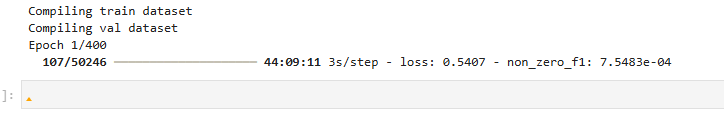

Tuning Some More

In [ ]:
# import tensorflow as tf
# from keras import layers, Input, Model, optimizers
# import kerastuner as kt  # or "from keras_tuner import Hyperband" depending on your installation

# Assume that all your custom functions and metrics (e.g. tile_to_batch, CustomBinaryFocalLoss,
# CustomNoBackgroundF1Score, CustomConditionalF1Score, CustomFalsePositiveDistance,
# CustomNoBackgroundAUC, CustomNoBackgroundAccuracy, CustomNoBackgroundPrecision,
# CustomNoBackgroundRecall, CustomBackgroundOnlyF1Score) are already imported/defined.

@utils.register_keras_serializable()
def create_dcnn_model_tunable(
    input_dim=5,
    sequence_length=5000,
    num_classes=5,
    early_dropout_val=0.0,
    middle_dropout_val=0.1,
    late_dropout_val=0.2
):
    K.clear_session()
    
    inputs = Input(shape=(sequence_length, input_dim))
    
    # Positional encoding block.
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_classes)(positions)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    pos_encoding = layers.Lambda(tile_to_batch)([pos_encoding, inputs])
    
    concat_input = layers.Concatenate(axis=-1)([inputs, pos_encoding])
    
    # First convolution branch.
    cnn = layers.Conv1D(filters=64, kernel_size=9, activation='relu', padding='same')(concat_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(early_dropout_val)(cnn)
    
    # Dilated convolution blocks.
    skip = concat_input
    skip = layers.Conv1D(filters=64, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=64, kernel_size=9, dilation_rate=1, activation='relu', padding='same')(skip)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(early_dropout_val)(dcnn)
    low_dcnn = dcnn
    
    dcnn = layers.Conv1D(filters=64, kernel_size=9, dilation_rate=2, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(early_dropout_val)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=160, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=4, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    
    dcnn = layers.Conv1D(filters=160, kernel_size=9, dilation_rate=8, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=192, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=16, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=32, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=192, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=64, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    
    dcnn = layers.Conv1D(filters=192, kernel_size=9, dilation_rate=128, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(middle_dropout_val)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    second_concat = layers.Concatenate(axis=-1)([concat_input, cnn, dcnn, low_dcnn])
    
    # "Dense" layers implemented as 1D convolutions.
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(second_concat)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(late_dropout_val)(dense)
    
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(late_dropout_val)(dense)
    
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='sigmoid')(dense)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


# loss_fn = CustomBinaryFocalLoss(
#         dominant_class_index=0,
#         dominant_correct_multiplier=0.98,
#         dominant_incorrect_multiplier=2.5,
#         other_class_true_positive_multiplier=0.075,
#         other_class_false_negative_multiplier=5.5,
#         other_class_false_positive_multiplier=2.0,
#         other_class_true_negative_multiplier=0.98,
#         smoothing_multiplier=0.06,
#         smoothing_as_correct=True,
#         threshold=0.5,
#         focal_gamma=3.0,
#         focal_alpha=0.15
#     )



def build_model(hp):
    # Tune dropout rates.
    early_dropout = hp.Float('early_dropout', min_value=0.0, max_value=0.3, step=0.1, default=0.1)
    middle_dropout = hp.Float('middle_dropout', min_value=0.0, max_value=0.3, step=0.1, default=0.1)
    late_dropout = hp.Float('late_dropout', min_value=0.1, max_value=0.4, step=0.1, default=0.2)
    
    # Tune the learning rate or rate scheduler.
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log', default=0.000534)
    decay_steps = 15000
    initial_learning_rate = hp.Float('initial_learning_rate', min_value=0.0001, max_value=0.01, sampling='log', default=0.001)
    warmup_steps = hp.Int('warmup_steps', min_value=800, max_value=1500, step=100, default=1000)
    target_learning_rate = hp.Float('target_learning_rate', min_value=0.001, max_value=0.1, sampling='log', default=0.01)
    lr_warmup_decayed_fn = optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
        warmup_steps=warmup_steps
    )
    
    # Tune the focal loss parameters.
    dominant_correct_multiplier = hp.Float('dominant_correct_multiplier', min_value=0.95, max_value=1.0, step=0.01, default=0.98)
    dominant_incorrect_multiplier = hp.Float('dominant_incorrect_multiplier', min_value=1.0, max_value=3.0, step=0.5, default=2.5)
    other_class_true_positive_multiplier = hp.Float('other_class_true_positive_multiplier', min_value=0.05, max_value=0.1, step=0.01, default=0.075)
    other_class_false_negative_multiplier = hp.Float('other_class_false_negative_multiplier', min_value=5.0, max_value=6.0, step=0.5, default=5.5)
    other_class_false_positive_multiplier = hp.Float('other_class_false_positive_multiplier', min_value=1.0, max_value=5.0, step=1.0, default=2.0)
    other_class_true_negative_multiplier = hp.Float('other_class_true_negative_multiplier', min_value=0.95, max_value=1.0, step=0.01, default=0.98)
    smoothing_multiplier = hp.Float('smoothing_multiplier', min_value=1.0, max_value=3.0, step=0.5, default=0.0)
    # Here we keep smoothing_as_correct fixed to False and threshold fixed to 0.5.
    focal_gamma = hp.Float('focal_gamma', min_value=1.0, max_value=4.0, step=0.5, default=2.0)
    focal_alpha = hp.Float('focal_alpha', min_value=0.05, max_value=0.5, step=0.05, default=0.25)
    
    # Build the model with the tunable dropout parameters.
    model = create_dcnn_model_tunable(
        input_dim=5,
        sequence_length=5000,
        num_classes=5,
        early_dropout_val=early_dropout,
        middle_dropout_val=middle_dropout,
        late_dropout_val=late_dropout
    )
    
    # Instantiate your custom loss with the tuned parameters.
    loss_fn = CustomBinaryFocalLoss(
        dominant_class_index=0,
        dominant_correct_multiplier=dominant_correct_multiplier,
        dominant_incorrect_multiplier=dominant_incorrect_multiplier,
        other_class_true_positive_multiplier=other_class_true_positive_multiplier,
        other_class_false_negative_multiplier=other_class_false_negative_multiplier,
        other_class_false_positive_multiplier=other_class_false_positive_multiplier,
        other_class_true_negative_multiplier=other_class_true_negative_multiplier,
        smoothing_multiplier=smoothing_multiplier,
        smoothing_as_correct=False,
        threshold=0.5,
        focal_gamma=focal_gamma,
        focal_alpha=focal_alpha
    )
    
    # Define your optimizer using the tuned learning rate.
    optimizer = optimizers.Adam(learning_rate=lr_warmup_decayed_fn)
    
    # 'checkpoints/epoch-032-val_no_background_f1-0.6029.keras' chosen due to good val f1 with an excellent false positive distance
    
    # To load in model weights for re-tuning
    model.load_weights('checkpoints/epoch-032-val_no_background_f1-0.6029.keras')
    
    # You can use the same metrics list defined earlier.
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=metrics_lst
    )
    
    
    
    return model


# Set up the tuner. For example, using Hyperband:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_false_positive_distance", direction="min"),
    max_epochs=10,
    factor=3,
    directory=models_path + 'Tuning Data/DCNN_Tuner_11',
    project_name='dcnn_tuning',
    overwrite=False
)

# Optionally, print a summary of the search space.
# tuner.search_space_summary()

# Then, when you have your training and validation data ready (e.g. train_data, val_data), start the search:
# tuner.search(train_data, validation_data=val_data, epochs=50, callbacks=[...])

# After the search is complete, you can retrieve the best model:
# best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from DCNN_Tuner_11/dcnn_tuning/tuner0.json


In [ ]:

max_time_seconds = 3600/2  # 1 hour is 3600 seconds
batch_size = 28
epochs = 10  # Set high enough to allow stopping by time
steps_per_epoch = 1500

print('Compiling train dataset')
train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=True,
                                shuffle_buffer=5000,
                                total_records=200985,
                                num_to_drop=1 # Batch size 28 leaves remainder of 1 record
                                )
train_dataset = train_dataset.repeat()
print('Compiling val dataset')
val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=False,
                                shuffle_buffer=5000,
                                total_records=23645,
                                num_to_drop=13, # Batch size 28 leaves remainder of 13 records
                                seed=42 # Seed for dropping the same 13 records every time
                                )

# test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=11824,
#                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 8 records every time
#                                 )
# tuner = kt.Hyperband(
# tune_dcnn_model,
# # objective='val_loss',
# objective=kt.Objective('val_no_background_f1', direction='max'),
# max_epochs=10,
# factor=3,
# directory= models_path + 'Tuning Data/DCNN_Tuner_8',
# project_name='dcnn_hyperparam_opt',
# overwrite=False
# )

# stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
time_limit_callback = TimeLimit(max_time_seconds=max_time_seconds)

tuner.search(train_dataset, epochs=10, steps_per_epoch = steps_per_epoch, validation_data=val_dataset, callbacks=[early_stopping_cb, time_limit_callback, CleanupCallback()])

tuner.results_summary()

# Retrieve the best model and hyperparameters:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 15 Complete [00h 37m 37s]
val_false_positive_distance: 98.74201202392578

Best val_false_positive_distance So Far: 0.0
Total elapsed time: 19h 04m 19s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
0.2               |0.2               |early_dropout
0.1               |0                 |middle_dropout
0.1               |0.3               |late_dropout
0.0015604         |0.00013615        |initial_learning_rate
1400              |800               |warmup_steps
0.0013153         |0.040076          |target_learning_rate
1                 |0.97              |dominant_correct_multiplier
2.5               |2.5               |dominant_incorrect_multiplier
0.08              |0.09              |other_class_true_positive_multiplier
6                 |5.5               |other_class_false_negative_multiplier
4                 |5                 |other_class_false_positive_multiplier
0.95              |0.96              |other_class_true_negative_multiplier


KeyboardInterrupt: 

In [12]:
print(tuner.results_summary(16))

Results summary
Results in DCNN_Tuner_11/dcnn_tuning
Showing 16 best trials
Objective(name="val_false_positive_distance", direction="min")

Trial 0007 summary
Hyperparameters:
early_dropout: 0.2
middle_dropout: 0.0
late_dropout: 0.30000000000000004
initial_learning_rate: 0.00013614821336150945
warmup_steps: 800
target_learning_rate: 0.04007628819445929
dominant_correct_multiplier: 0.97
dominant_incorrect_multiplier: 2.5
other_class_true_positive_multiplier: 0.09
other_class_false_negative_multiplier: 5.5
other_class_false_positive_multiplier: 5.0
other_class_true_negative_multiplier: 0.96
smoothing_multiplier: 2.5
focal_gamma: 2.0
focal_alpha: 0.4
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.0

Trial 0003 summary
Hyperparameters:
early_dropout: 0.1
middle_dropout: 0.1
late_dropout: 0.30000000000000004
initial_learning_rate: 0.00045281895391567737
warmup_steps: 1300
target_learning_rate: 0.06393826148848877
dominant_correct_multiplier: 0.98
dominant_in

In [14]:
batch_size = 1
epochs = 400  # Set high enough to allow stopping by callback
steps_per_epoch = 7178

print('Compiling train dataset')
train_dataset = prep_dataset_from_tfrecord("TestValTrain/train_binary.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=True,
                                shuffle_buffer=1000,
                                total_records=200985,
                                num_to_drop=1 # Batch size 28 leaves remainder of 1 record
                                )

for X_batch, y_batch in train_dataset.take(1):
    for i in range(5000):
        print(X_batch[0][i], y_batch[0][i])
    # print("X shape:", X_batch.shape)
    # print("y shape:", y_batch.shape)
    # print("record_id:", record_id)
    # print("cstart:", cstart)
    # print("cend:", cend)
    # print("strand:", strand)
    
# # Create an initial state for the counts (one count per column, shape: (4,))
# ones_by_column = None
# for batch in train_dataset:
#     # Assume each batch is a tuple: (features, labels)
#     _, labels = batch  
#     # Slice to get the sub-tensor for columns 1-4 from the 1x5 portion
#     # If labels shape is (batch_size, 1, 5, 5000):
#     relevant_labels = labels[:, :, 1:5]  # shape: (batch_size, 4, 5000)
    
#     # Create a boolean mask where entries equal to 1.0 are True
#     ones_mask = tf.equal(relevant_labels, 1.0)
    
#     # Convert booleans to int and sum over the batch dimension (axis 0) and the 5000 dimension (axis 2)
#     batch_column_counts = tf.reduce_sum(tf.cast(ones_mask, tf.int64), axis=[0, 1])  # shape: (4,)
    
#     if ones_by_column is None:
#         ones_by_column = batch_column_counts
#     else:
#         ones_by_column += batch_column_counts

# print("Counts by column (indices 1-4):", ones_by_column.numpy())

Compiling train dataset
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), d

2025-03-04 00:16:19.987617: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of labels in each column: [265705, 265703, 392866, 392715], sum = 1316989, sparseness = 1316989/(200984*5000) = 0.00131, Intron boundary labels: 40.3%, Exon Boundary Labels: 59.7%

Prior to transfer learning, the model had roughly a 50:50 shot at landing a bullseye for something that occurs 1.3 times out of 1000 in the data.

In [ ]:
'''This cell evaluates the validation data with each checkpoint'''

max_time_seconds = 3600*12  # 1 hour is 3600 seconds
batch_size = 28
epochs = 400  # Set high enough to allow stopping by callback
steps_per_epoch = 7178

# print('Compiling train dataset')
# train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=True,
#                                 shuffle_buffer=10000,
#                                 total_records=200985,
#                                 num_to_drop=1 # Batch size 28 leaves remainder of 1 record
#                                 )
# train_dataset = train_dataset.repeat()

print('Compiling val dataset')
val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=False,
                                shuffle_buffer=5000,
                                total_records=23645,
                                num_to_drop=13, # Batch size 28 leaves remainder of 13 records
                                seed=42 # Seed for dropping the same 13 records every time
                                )
# val_dataset = val_dataset.repeat()
# test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=11824,
#                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 8 records every time
#                                 )

# history = dcnn_model.fit(
#         train_dataset, 
#         validation_data=val_dataset,
#         # batch_size=batch_size,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)]
#         )

# print('Saving model...')
# dcnn_model.save("Finished_Model.keras")
# # upload_file("Finished_Model.keras", s3_bucket, "checkpoints/Finished_Model.keras)
# print(f"📁 Model saved!")


# loss_fn = CustomBinaryCrossentropyLoss(
#     dominant_class_index=0,
#     dominant_correct_multiplier=0.07,
#     dominant_incorrect_multiplier=2.5,
#     other_class_multiplier=2.0,
#     smoothing_multiplier=0.5
# )

loss_fn = CustomBinaryCrossentropyLoss(
        dominant_class_index=0,
        dominant_correct_multiplier=0.95,
        dominant_incorrect_multiplier=2.0,
        other_class_true_positive_multiplier=0.125,
        other_class_false_negative_multiplier=5.0,
        other_class_false_positive_multiplier=2.0,
        other_class_true_negative_multiplier=1.0,
        smoothing_multiplier=0.3,
        smoothing_as_correct=True
    )

# Define your checkpoint directory
checkpoint_dir = models_path + "checkpoints"

# Store results in a list
results_list = []

# Loop through all saved model files
for filename in sorted(os.listdir(checkpoint_dir)):  # Ensure sorted order
    if filename.endswith(".keras"):  # Adjust if using TensorFlow checkpoints
        model_path = os.path.join(checkpoint_dir, filename)
        print(f"Evaluating {filename}...")

        # Load the model (Include custom loss/metrics if necessary)
        model = models.load_model(model_path) 
        model.compile(
                    loss=loss_fn,
                    metrics=[
                        CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
                        # CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
                        CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
                        # CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
                        ]
                    )
            

        # Evaluate on validation dataset
        results = model.evaluate(val_dataset, verbose=1)  # Suppress output

        # Store results (Modify column names as needed)
        results_list.append({"Checkpoint": filename, "Results" : results})

# Convert results to a DataFrame
df_results = pd.DataFrame(results_list)

# Display the DataFrame
print(df_results)

# Save the DataFrame to a CSV file for later analysis
df_results.to_csv(models_path + "Results/validation_results.csv", index=False)

print("Validation results saved to 'Results/validation_results.csv'.")

Compiling val dataset
Evaluating epoch-001-val_loss-0.0529.keras...


I0000 00:00:1739865857.336202    8142 service.cc:146] XLA service 0x7f4e4c013b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739865857.336262    8142 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-18 01:04:17.385474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-18 01:04:17.511622: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-02-18 01:04:20.274926: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng30{k2=1,k4=2,k5=1,k6=0,k7=0} for conv (f32[448,192,1,313]{3,2,1,0}, u8[0]{0}) custom-call(f32[448,160,1,321]{3,2,1,0}, f32[192,160,1,9]{3,2,1,0}), window={size=1x9}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_

      3/Unknown 6s 29ms/step - background_only_f1: 0.9996 - loss: 0.0442 - no_background_f1: 0.3160

I0000 00:00:1739865862.762288    8142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - background_only_f1: 0.9995 - loss: 0.0532 - no_background_f1: 0.3967
Evaluating epoch-002-val_loss-0.0534.keras...


2025-02-18 01:04:45.578552: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-02-18 01:04:45.578675: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - background_only_f1: 0.9995 - loss: 0.0537 - no_background_f1: 0.3418
Evaluating epoch-003-val_loss-0.0534.keras...


2025-02-18 01:05:11.958751: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - background_only_f1: 0.9995 - loss: 0.0538 - no_background_f1: 0.2851
Evaluating epoch-004-val_loss-0.0538.keras...


2025-02-18 01:05:38.272482: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11415485918501342945


844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - background_only_f1: 0.9995 - loss: 0.0541 - no_background_f1: 0.2421
Evaluating epoch-005-val_loss-0.0522.keras...


2025-02-18 01:06:04.977580: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


844/844 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - background_only_f1: 0.9995 - loss: 0.0525 - no_background_f1: 0.3581
Evaluating epoch-006-val_loss-0.0526.keras...
844/844 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - background_only_f1: 0.9995 - loss: 0.0529 - no_background_f1: 0.2879
                        Checkpoint  \
0  epoch-001-val_loss-0.0529.keras   
1  epoch-002-val_loss-0.0534.keras   
2  epoch-003-val_loss-0.0534.keras   
3  epoch-004-val_loss-0.0538.keras   
4  epoch-005-val_loss-0.0522.keras   
5  epoch-006-val_loss-0.0526.keras   

                                             Results  
0  [0.05286713317036629, 0.40154725313186646, 0.9...  
1  [0.05337876081466675, 0.34328600764274597, 0.9...  
2  [0.05342801287770271, 0.2842392325401306, 0.99...  
3  [0.053841929882764816, 0.24166183173656464, 0....  
4  [0.052173957228660583, 0.3586251735687256, 0.9...  
5  [0.05256197229027748, 0.2876722812652588, 0.99...  
Validation results saved to 'validation_results.csv'.


In [77]:
print(results_list)

[{'Checkpoint': 'epoch-001-val_loss-0.0263.keras', 'Results': [0.02629547193646431, 0.4233812093734741, 0.4233812093734741, 0.9988483190536499, 0.9988483190536499, 0.9988483190536499, 0.4332113564014435]}, {'Checkpoint': 'epoch-003-val_loss-0.0247.keras', 'Results': [0.02472471073269844, 0.37515681982040405, 0.37515681982040405, 0.9988055229187012, 0.9988055229187012, 0.9988055229187012, 0.3802448809146881]}, {'Checkpoint': 'epoch-004-val_loss-0.0244.keras', 'Results': [0.02436007373034954, 0.518424928188324, 0.518424928188324, 0.9988994598388672, 0.9988994598388672, 0.9988994002342224, 0.5233819484710693]}, {'Checkpoint': 'epoch-005-val_loss-0.0243.keras', 'Results': [0.024295059964060783, 0.5021491050720215, 0.5021491050720215, 0.9988505244255066, 0.9988505244255066, 0.9988505244255066, 0.5132834911346436]}, {'Checkpoint': 'epoch-006-val_loss-0.0241.keras', 'Results': [0.024132538586854935, 0.41637763381004333, 0.41637763381004333, 0.9988260269165039, 0.9988260269165039, 0.9988260269

In [ ]:
# # Define your checkpoint directory and file pattern.
# checkpoint_dir = models_path + "checkpoints"
# # Assume your checkpoint files follow the pattern 'cp-XXXX.ckpt'
# checkpoint_pattern = os.path.join(checkpoint_dir, "epoch-*-val_loss-*.keras")

# # Find the most recent checkpoint file.
# checkpoint_files = glob.glob(checkpoint_pattern)
# if checkpoint_files:
#     latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
#     print("Resuming from checkpoint:", latest_checkpoint)
    
#     # Load the entire model from the checkpoint.
#     dcnn_model = models.load_model(latest_checkpoint)
#     dcnn_model.compile()
    
#     epoch_str = os.path.basename(latest_checkpoint).split('-')[1]
#     # Remove any file extension; adjust the splitting as needed.
#     epoch_num = int(''.join(filter(str.isdigit, epoch_str)))
#     initial_epoch = epoch_num
# else:
#     print("No checkpoint found. Starting training from scratch.")
#     # Build and compile your model as you normally do.
#     dcnn_model = create_dcnn_model(5, 5000, 5)
#     dcnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.000686),
#                     loss=custom_binary_crossentropy_loss(
#                         dominant_class_index=0,
#                         dominant_correct_multiplier=0.07,
#                         dominant_incorrect_multiplier=2.5,
#                         other_class_multiplier=2.0,
#                         smoothing_multiplier=0.5
#                     ),
#                     metrics=[
#                         CustomNoBackgroundF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomNoBackgroundF1Score(num_classes=5, average='macro', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='weighted', threshold=0.5),
#                         CustomBackgroundOnlyF1Score(num_classes=5, average='macro', threshold=0.5)
#                         ]
#                     )
#     dcnn_model.summary()
#     initial_epoch = 0

# # Continue training.
# history = dcnn_model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=epochs,
#     steps_per_epoch=steps_per_epoch,
#     callbacks=[early_stopping_cb, checkpoint_cb, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)],
#     initial_epoch=initial_epoch  # This tells Keras to start counting epochs from here.
# )

# # Save final model if needed.
# dcnn_model.save("Finished_Model.keras")
# print("📁 Model saved!")


In [79]:
dcnn_model.summarize()

AttributeError: 'Functional' object has no attribute 'summarize'